In [1]:
# modelagem e dados
import torch
from torch import nn, optim

# plotting e visualização
from torchsummary import summary
import matplotlib.pyplot as plt

# outros
import numpy as np
from tqdm import tqdm

In [2]:
from model.model_encoder_bilinear import SegNet, transforms
from dataset.dataloader_camvid import train_loader, val_loader, test_loader


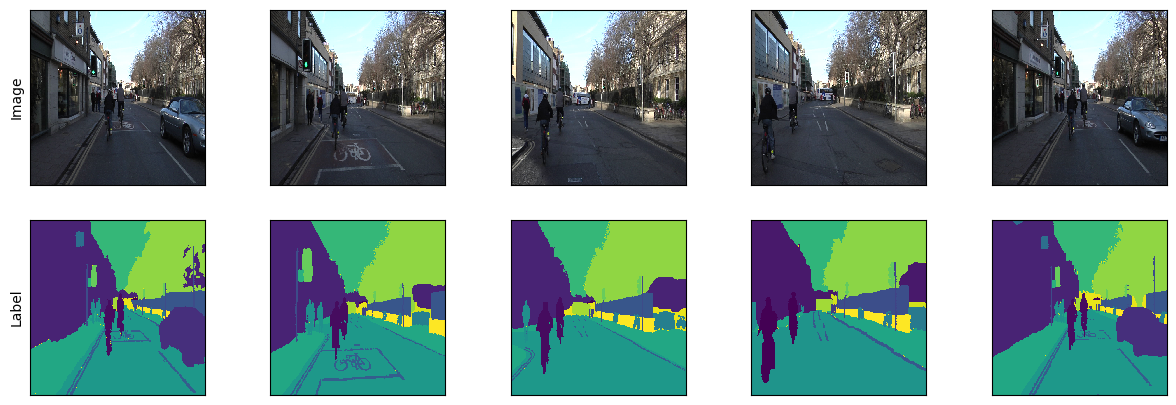

In [3]:
w = 5
fig, ax = plt.subplots(2, w, figsize=(15, 5))

ax[0][0].set_ylabel("Image")
ax[1][0].set_ylabel("Label")

for j in range(w):
    instances, targets = next(iter(train_loader))
    ax[0][j].imshow(instances[0].permute(1, 2, 0).numpy().astype("uint8"), cmap="gray", interpolation="None")
    ax[0][j].set_xticks([])
    ax[0][j].set_yticks([])

    ax[1][j].imshow((torch.argmax(targets[0].permute(1, 2, 0), dim=2)).numpy().astype("uint8"), interpolation="None")
    ax[1][j].set_xticks([])
    ax[1][j].set_yticks([])

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [5]:
model = SegNet().to(device)
model.load_state_dict(torch.load(r"model\weights\best_pretrained_bilinear_road.zip"))
summary(SegNet().to(device), (3, 224, 224), 1, device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 224, 224]           1,792
            Conv2d-2          [1, 64, 224, 224]           1,792
              ReLU-3          [1, 64, 224, 224]               0
       BatchNorm2d-4          [1, 64, 224, 224]             128
            Conv2d-5          [1, 64, 224, 224]          36,928
            Conv2d-6          [1, 64, 224, 224]          36,928
              ReLU-7          [1, 64, 224, 224]               0
       BatchNorm2d-8          [1, 64, 224, 224]             128
         MaxPool2d-9          [1, 64, 112, 112]               0
           Conv2d-10         [1, 128, 112, 112]          73,856
           Conv2d-11         [1, 128, 112, 112]          73,856
             ReLU-12         [1, 128, 112, 112]               0
      BatchNorm2d-13         [1, 128, 112, 112]             256
           Conv2d-14         [1, 128, 1

In [7]:
train_losses = list()
valid_losses = list()

In [8]:
EPOCHS = 25
lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

In [11]:
def train_step(model, loader, loss_fn, optimizer, device) -> float:
  train_loss = 0
  for X, Y in loader:
    X = transforms(X)
    y_pred = model(X.to(device))
    loss = loss_fn(y_pred, Y.to(device))
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  return train_loss / len(loader)


def validation_step(model, loader, loss_fn, device) -> float:
  loss = 0
  with torch.no_grad():
    for X, Y in loader:
      X = transforms(X)
      y_pred = model(X.to(device))
      loss += loss_fn(y_pred, Y.to(device)).item()
  return loss / len(loader)

In [12]:
from tqdm import tqdm
from copy import deepcopy

def train_model():
  for epoch in tqdm(range(EPOCHS)):
    train_losses.append(train_step(model, train_loader, loss_fn, optimizer, device))
    valid_losses.append(validation_step(model, val_loader, loss_fn, device))
    if valid_losses[-1] == min(valid_losses):
      best_model = deepcopy(model)
    print("\fLoss: {}\n".format(valid_losses[-1]))
  return best_model

In [13]:
model.freeze_encoder_block()
best_model = train_model()

  4%|▍         | 1/25 [00:41<16:36, 41.53s/it]

Loss: 2.7038004398345947



  8%|▊         | 2/25 [01:20<15:19, 39.97s/it]

Loss: 2.670267105102539



 12%|█▏        | 3/25 [01:59<14:26, 39.40s/it]

Loss: 2.6578128337860107



 16%|█▌        | 4/25 [02:37<13:41, 39.12s/it]

Loss: 2.650933027267456



 20%|██        | 5/25 [03:16<12:58, 38.94s/it]

Loss: 2.6411569118499756



 24%|██▍       | 6/25 [03:55<12:18, 38.86s/it]

Loss: 2.6346232891082764



 28%|██▊       | 7/25 [04:33<11:38, 38.78s/it]

Loss: 2.630082368850708



 32%|███▏      | 8/25 [05:12<10:58, 38.75s/it]

Loss: 2.6255040168762207



 36%|███▌      | 9/25 [05:51<10:19, 38.72s/it]

Loss: 2.621380567550659



 40%|████      | 10/25 [06:29<09:40, 38.71s/it]

Loss: 2.617595672607422



 44%|████▍     | 11/25 [07:08<09:01, 38.68s/it]

Loss: 2.6141395568847656



 48%|████▊     | 12/25 [07:47<08:22, 38.69s/it]

Loss: 2.6124470233917236



 52%|█████▏    | 13/25 [08:25<07:44, 38.70s/it]

Loss: 2.611133098602295



 56%|█████▌    | 14/25 [09:04<07:05, 38.70s/it]

Loss: 2.608431339263916



 60%|██████    | 15/25 [09:43<06:27, 38.72s/it]

Loss: 2.6041958332061768



 64%|██████▍   | 16/25 [10:22<05:48, 38.72s/it]

Loss: 2.600785255432129



 68%|██████▊   | 17/25 [11:00<05:09, 38.74s/it]

Loss: 2.5987837314605713



 72%|███████▏  | 18/25 [11:39<04:31, 38.74s/it]

Loss: 2.597538471221924



 76%|███████▌  | 19/25 [12:18<03:53, 38.84s/it]

Loss: 2.5969181060791016



 80%|████████  | 20/25 [12:57<03:14, 38.84s/it]

Loss: 2.5967354774475098



 84%|████████▍ | 21/25 [13:36<02:35, 38.79s/it]

Loss: 2.5972039699554443



 88%|████████▊ | 22/25 [14:14<01:56, 38.76s/it]

Loss: 2.5977108478546143



 92%|█████████▏| 23/25 [14:53<01:17, 38.77s/it]

Loss: 2.5970098972320557



 96%|█████████▌| 24/25 [15:32<00:38, 38.77s/it]

Loss: 2.595080614089966



100%|██████████| 25/25 [16:11<00:00, 38.84s/it]

Loss: 2.593452215194702



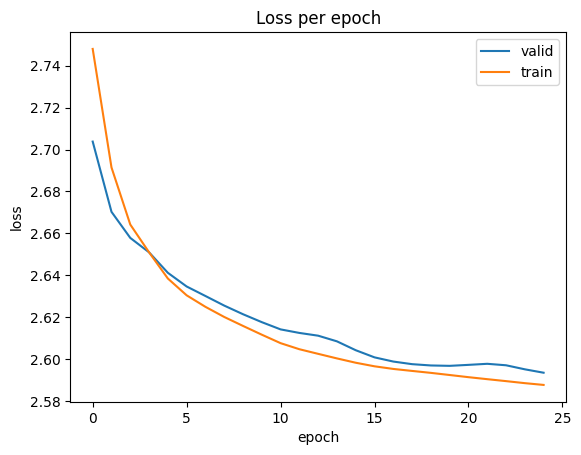

In [14]:
def plot_loss(loss_train, loss_valid): 
  plt.plot(loss_valid, label='valid')
  plt.plot(loss_train, label='train')
  plt.title('Loss per epoch')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend()
  plt.show()

plot_loss(train_losses, valid_losses)

In [21]:
model.unfreeze_encoder_block()
best_model = train_model()

  4%|▍         | 1/25 [01:05<26:09, 65.38s/it]

Loss: 2.5867621898651123



  8%|▊         | 2/25 [02:16<26:21, 68.75s/it]

Loss: 2.5870864391326904



 12%|█▏        | 3/25 [03:27<25:32, 69.67s/it]

Loss: 2.5875093936920166



 16%|█▌        | 4/25 [04:38<24:32, 70.12s/it]

Loss: 2.5873007774353027



 20%|██        | 5/25 [05:48<23:25, 70.27s/it]

Loss: 2.5870893001556396



 24%|██▍       | 6/25 [06:59<22:21, 70.58s/it]

Loss: 2.587123155593872



 28%|██▊       | 7/25 [08:10<21:11, 70.66s/it]

Loss: 2.587289571762085



 32%|███▏      | 8/25 [09:21<20:02, 70.72s/it]

Loss: 2.5873546600341797



 36%|███▌      | 9/25 [10:32<18:52, 70.79s/it]

Loss: 2.5876758098602295



 40%|████      | 10/25 [11:43<17:42, 70.85s/it]

Loss: 2.5880980491638184



 44%|████▍     | 11/25 [12:54<16:32, 70.88s/it]

Loss: 2.5879979133605957



 48%|████▊     | 12/25 [14:05<15:21, 70.89s/it]

Loss: 2.586914539337158



 52%|█████▏    | 13/25 [15:15<14:10, 70.84s/it]

Loss: 2.586148738861084



 56%|█████▌    | 14/25 [16:26<12:59, 70.89s/it]

Loss: 2.585885763168335



 60%|██████    | 15/25 [17:33<11:34, 69.46s/it]

Loss: 2.585939407348633



 60%|██████    | 15/25 [17:46<11:50, 71.09s/it]


KeyboardInterrupt: 

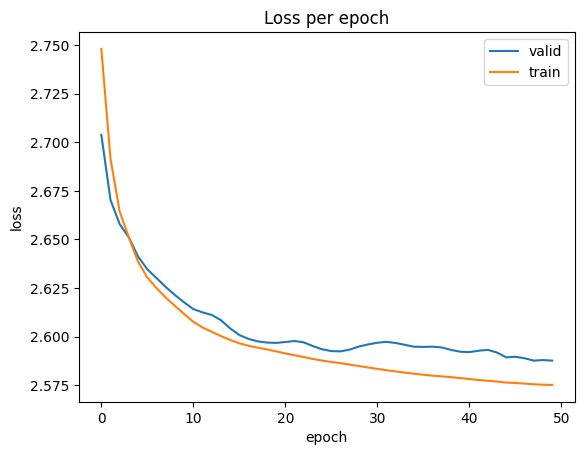

In [ ]:
def plot_loss(loss_train, loss_valid):
  plt.plot(loss_valid, label='valid')
  plt.plot(loss_train, label='train')
  plt.title('Loss per epoch')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend()
  plt.show()

plot_loss(train_losses, valid_losses)

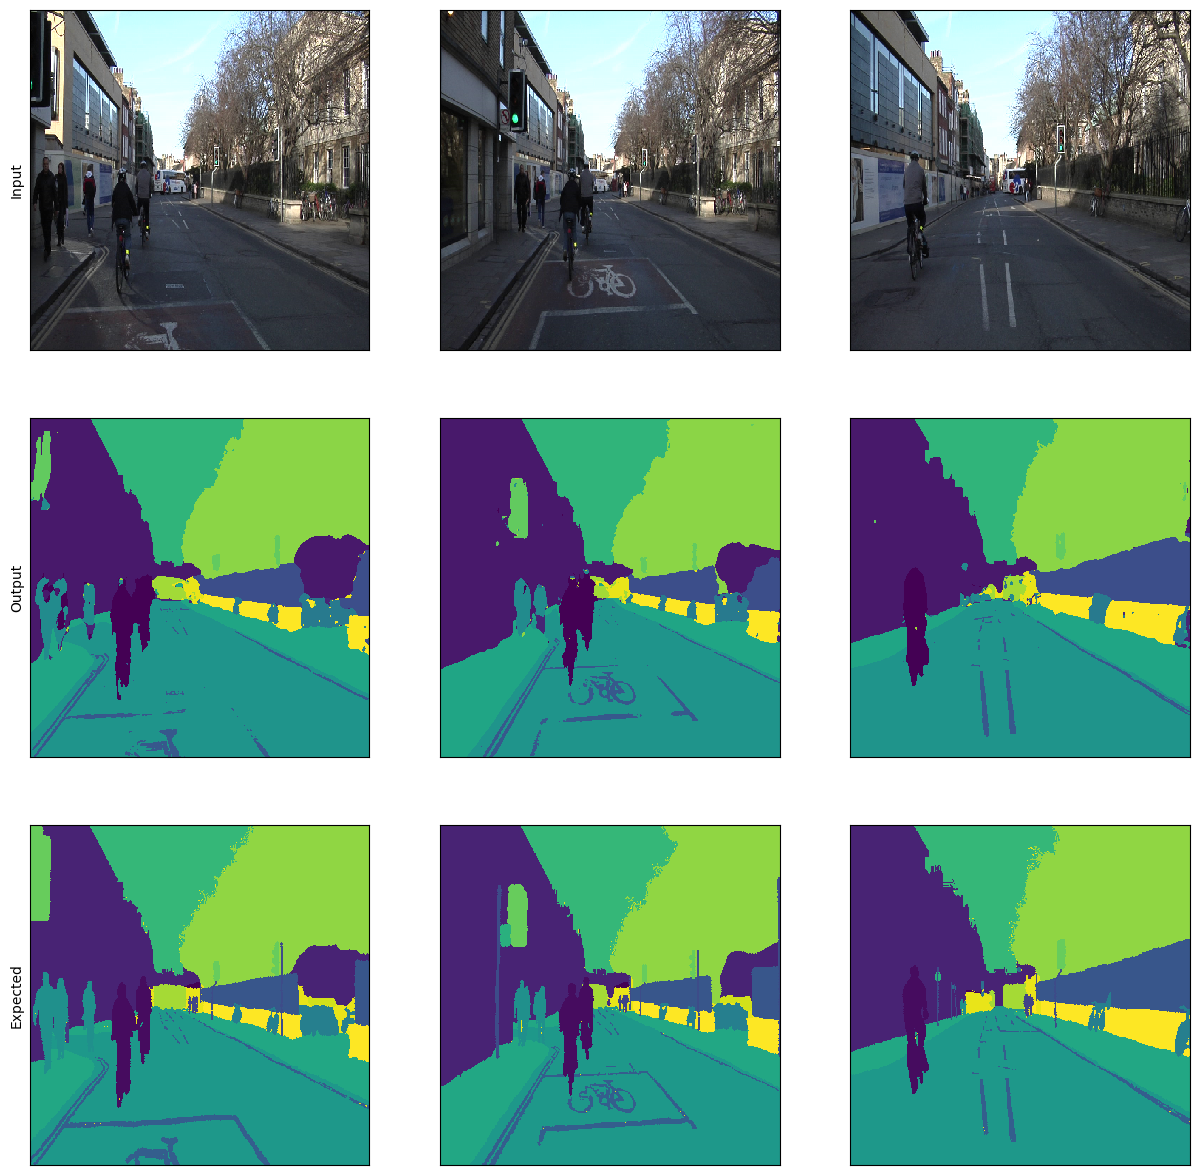

In [22]:
w = 3
fig, ax = plt.subplots(3, w, figsize=(15, 15))

ax[0][0].set_ylabel("Input")
ax[1][0].set_ylabel("Output")
ax[2][0].set_ylabel("Expected")
with torch.no_grad():
    for j in range(w):
        instances, targets = next(iter(test_loader))
        ax[0][j].imshow(instances[0].permute(1, 2, 0).numpy().astype("uint8"), cmap="gray", interpolation="None")
        ax[0][j].set_xticks([])
        ax[0][j].set_yticks([])
        instances = transforms(instances)

        ax[1][j].imshow(torch.argmax(model(instances[0].to(device).unsqueeze(0)).squeeze(0).permute(1, 2, 0), dim=2).cpu().numpy().astype("uint8"), interpolation="None")
        ax[1][j].set_xticks([])
        ax[1][j].set_yticks([])

        ax[2][j].imshow((torch.argmax(targets[0].permute(1, 2, 0), dim=2)).numpy().astype("uint8"), interpolation="None")
        ax[2][j].set_xticks([])
        ax[2][j].set_yticks([])

In [ ]:
from utils.evaluation.multi_channel_iou import IoU
iou = IoU().to(device)

In [23]:
iou_test = torch.zeros([1, 34]).to(device)

for instances, targets in test_loader:
    predict = torch.zeros(targets.shape).to(device)
    instances = transforms(instances)
    res = torch.argmax(model(instances.to(device)), dim=-3)
    for ch in range(targets.shape[1]):
        predict[:, ch, :, :] = (res == ch)
    iou_test += iou(predict, targets.to(device))

iou_test /= len(test_loader)
iou_test

tensor([[0.6667, 0.8922, 1.0000, 0.0000, 0.8464, 1.0000, 0.9183, 0.0819, 0.2727,
         0.0000, 0.0000, 0.8231, 0.6348, 1.0000, 0.0583, 1.0000, 0.6938, 1.0000,
         0.5844, 0.9500, 1.0000, 0.9054, 0.2727, 0.9538, 1.0000, 1.0000, 0.6261,
         1.0000, 0.9407, 0.5660, 1.0000, 0.1818, 0.2375, 0.7874]],
       device='cuda:0')

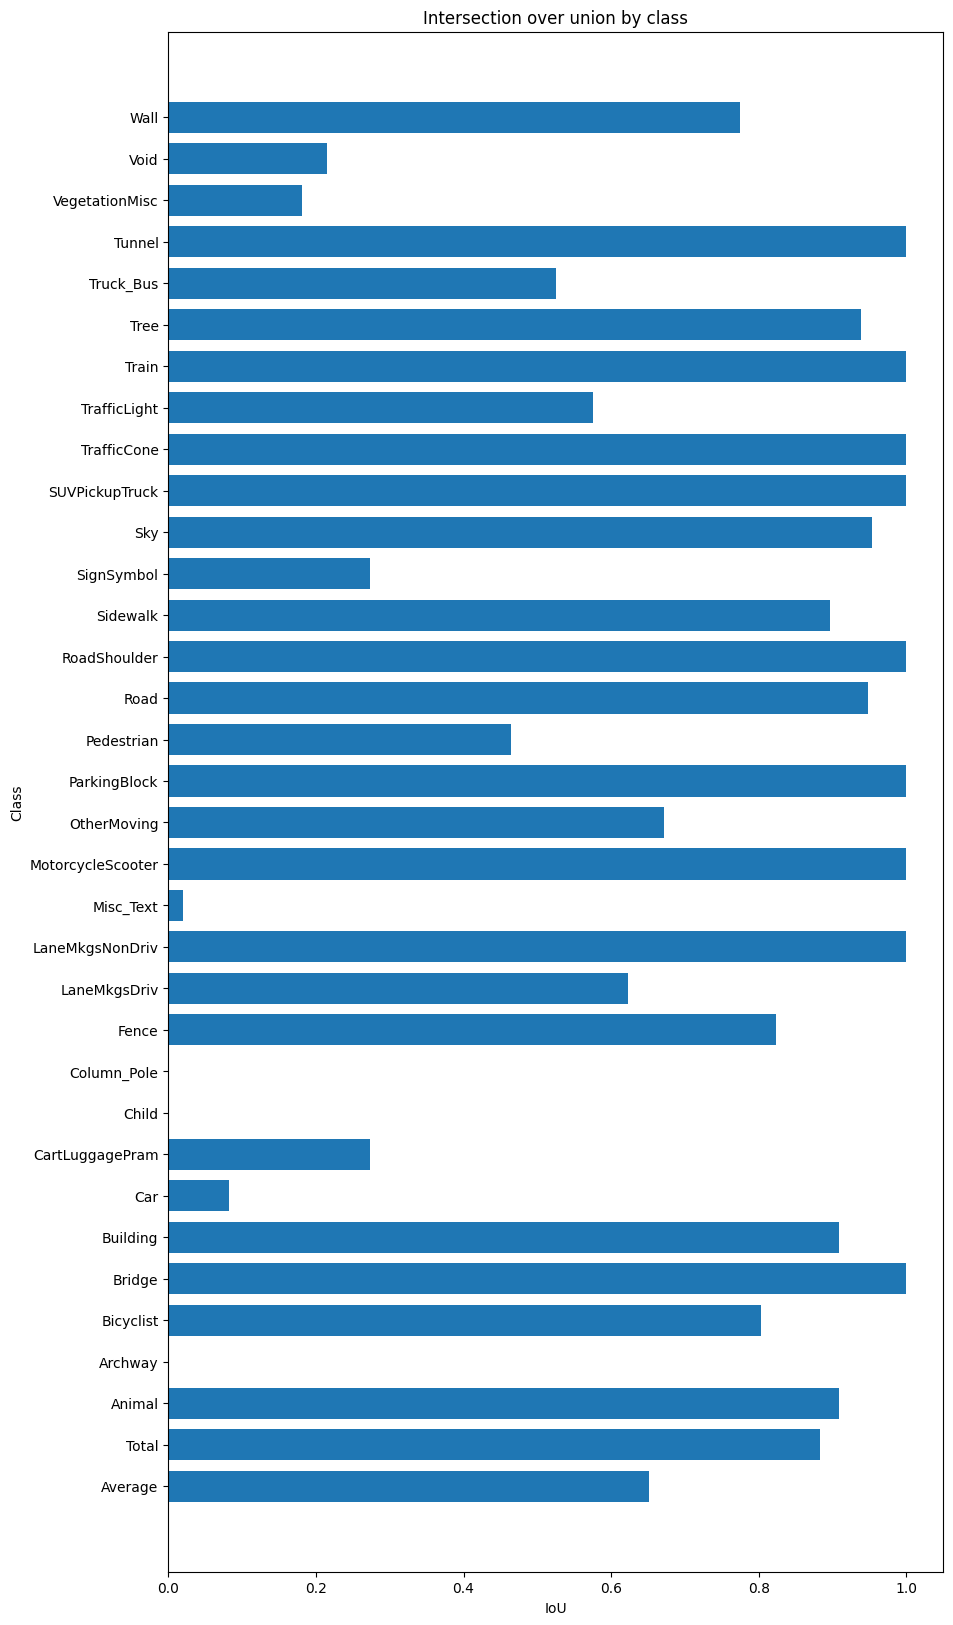

In [ ]:
classes = ["Average", "Total", "Animal", "Archway", "Bicyclist", "Bridge", "Building", "Car", "CartLuggagePram", "Child", "Column_Pole", "Fence", "LaneMkgsDriv", "LaneMkgsNonDriv", "Misc_Text", "MotorcycleScooter", "OtherMoving", "ParkingBlock", "Pedestrian", "Road", "RoadShoulder", "Sidewalk", "SignSymbol", "Sky", "SUVPickupTruck", "TrafficCone", "TrafficLight", "Train", "Tree", "Truck_Bus", "Tunnel", "VegetationMisc", "Void", "Wall", ]
values = list(iou_test.squeeze().cpu().numpy())

fig = plt.figure(figsize = (10, 20))

plt.barh(classes, values, height=0.75)
 
plt.xlabel("IoU")
plt.ylabel("Class")
plt.title("Intersection over union by class")
plt.show()

In [ ]:
to_save = False

if to_save:
    torch.save(model.state_dict(), r"model\weights\best_pretrained_bilinear_road.zip")